<a href="https://colab.research.google.com/github/Nishant-Ramakuru/Inference-based-GNNS/blob/main/simulations/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import Functions

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import random
from torch.utils.data import Dataset
import argparse, os, time
from torch.nn import init
import math
import networkx as nx
import pandas as pd
import os 

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/GNNs')

from utils_functions import *
from models import RecurrentBaseline, SingleRNNBaseline, JointRNNBaseline, FullyConnectedBaseline, DNRI, RefMLPEncoder, GraphRNNDecoder, RecurrentBaseline_DynamicVars, FullyConnectedBaseline_DynamicVars, BaseNRI,DNRI_DynamicVars

Dataset

In [5]:
df = pd.read_pickle("/content/drive/MyDrive/GNNs/boids_buffer_10_15k.csv")

In [6]:
df.shape

(15000, 4)

In [7]:
df.head()

,R,theta,velocity,trajectory
0,"[[707.02014, 803.3247], [872.8785, 992.9619], ...","[4.3974066, 5.3883123, 1.890375, 5.7133555, 3....","[[-2.0450733, -4.497138], [3.1280887, -3.90064...","[[707.02014, 803.3247, -2.0450733, -4.497138],..."
1,"[[705.57416, 798.53864], [876.0066, 989.0613],...","[4.4348707, 5.3883123, 0.7724528, 5.7133555, 3...","[[-1.446004, -4.786043], [3.1280887, -3.900648...","[[705.57416, 798.53864, -1.446004, -4.786043],..."
2,"[[704.2475, 793.71796], [879.1347, 985.16064],...","[4.4514513, 5.3883123, 0.743052, 5.7133555, 3....","[[-1.3266804, -4.8207207], [3.1280887, -3.9006...","[[704.2475, 793.71796, -1.3266804, -4.8207207]..."
3,"[[702.98267, 788.88055], [882.26276, 981.25995...","[4.461328, 5.3883123, 0.7353079, 5.7133555, 3....","[[-1.2648168, -4.8373585], [3.1280887, -3.9006...","[[702.98267, 788.88055, -1.2648168, -4.8373585..."
4,"[[701.7574, 784.033], [885.39087, 977.3593], [...","[4.468065, 5.3883123, 0.7278318, 5.7133555, 3....","[[-1.2252507, -4.8475423], [3.1280887, -3.9006...","[[701.7574, 784.033, -1.2252507, -4.8475423], ..."


Parameters

In [8]:
params = {}
tau = 1
params['use_adam'] = True
params['test_burn_in_steps'] =10
params['num_time_steps'] = 50
params['data_path']= '/content/MyDrive/GNNs'
params['num_train'] = 5000
params['num_val'] = 2500
params['num_test']= 2500
params['load_model'] = False
params['load_best_model'] = False
params['model_type'] = 'RNN'
#params['graph_type'] = ['static', 'dynamic']
params['graph_type'] = 'dynamic'
params['encoder_no_factor'] = True
params['num_epochs'] = 100
params['num_vars'] = params['num_agents'] = 10
params['input_noise_type'] = 'none'
params['input_size'] = 4
params['nll_loss_type'] = 'gaussian'
params['prior_variance'] = 5e-5
params['batch_size'] = 64
params['val_batch_size'] = 64
params['accumulate_steps'] = 40
params['num_edge_types'] = 1
params['encoder_dropout'] = 0.0
params['encoder_hidden'] = 256
params['encoder_rnn_hidden'] = 64
params['encoder_rnn_type'] = 'lstm'
params['decoder_rnn_type'] = 'lstm'
params['encoder_mlp_num_layers'] = 1
params['encoder_mlp_hidden'] = 256
params['prior_num_layers'] = 1
params['prior_hidden_size'] = 256
params['gpu'] = False
params['decoder_hidden'] = 256
params['skip_first'] = False
params['decoder_dropout'] = 0.0
params['decoder_type'] = None
params['lr'] = 5e-4
params['mode'] = "train"

params['working_dir'] =params['output_dir'] =  ('/content/MyDrive/GNNs')

In [9]:
agent = 9

50


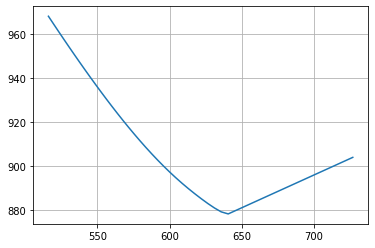

In [10]:
x = []
y = []

for i in range(50):
  x.append(df.trajectory[i][agent][0])
  y.append(df.trajectory[i][agent][1])

%matplotlib inline
print(len(x))
plt.plot(x,y)
plt.grid()
plt.show()

In [11]:
data = []
for w in range(len(df)):
  
  state = np.array(df.R[w])
  D = list()
  for a,i in enumerate(state):
    d= []
    for b,j in enumerate(state):
      eDistance = math.hypot(i[0] - j[0], i[1] - j[1])
      if a == b:
        d.append(0)
      elif int(eDistance) <= 45:
        d.append(1)
      else:
        d.append(0)
    D.append(d)

  data.append(np.array(D))
edge_data = np.array(data)
#all_data = np.array(list(df.trajectory.transpose()))
all_data = df.trajectory.to_numpy()

adj_array = []
#print(edge_data.shape)
for time_step in range(len(edge_data)):
  edge = []
  for i in range(len(edge_data[0])):
    edge = edge + list(list(edge_data[time_step][i][:i])+list(edge_data[time_step][i][i+1:]))
    
  #print(len(edge[0].shape))
  adj_array.append(edge)

edge_data = np.array(adj_array)

50


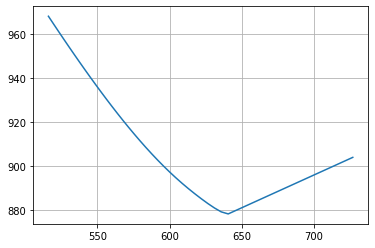

In [12]:
x = []
y = []
for i in range(50):
  x.append(all_data[i][agent][0])
  y.append(all_data[i][agent][1])

%matplotlib inline
print(len(x))
plt.plot(x,y)
plt.grid()
plt.show()

In [13]:
all_data = np.stack(all_data)
train_data = torch.FloatTensor(all_data[:params['num_train']])
val_data = torch.FloatTensor(all_data[params['num_train']:params['num_train']+params['num_val']])
test_data = torch.FloatTensor(all_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

train_edges = torch.FloatTensor(edge_data[:params['num_train']])
val_edges = torch.FloatTensor(edge_data[params['num_train']:params['num_train']+params['num_val']])
test_edges = torch.FloatTensor(edge_data[params['num_train']+params['num_val']:params['num_train']+params['num_val']+params['num_test']])

In [14]:
del all_data, df,edge_data, data

In [15]:
print("Train Shape:", train_data.shape,"\n", 
       "Val Shape:", val_data.shape,"\n",
      "Test Shape:", test_data.shape)

Train Shape: torch.Size([5000, 10, 4]) 
 Val Shape: torch.Size([2500, 10, 4]) 
 Test Shape: torch.Size([2500, 10, 4])


50


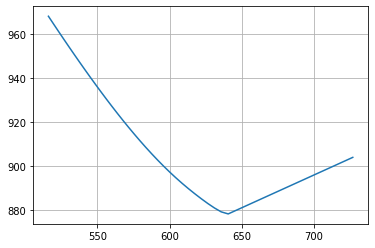

In [16]:
x = []
y = []
for time_step in range(50):
  x.append(train_data[time_step][agent][0])
  y.append(train_data[time_step][agent][1])

%matplotlib inline
print(len(x))
plt.plot(x,y)
plt.grid()
plt.show()

In [17]:
train_data = train_data.reshape([int(params["num_train"]/50),50,10,4])
val_data = val_data.reshape([int(params["num_val"]/50),50,10,4])
test_data = test_data.reshape([int(params["num_test"]/50),50,10,4])

train_edges = train_edges.reshape([int(params['num_train']/50),50,90])
val_edges = val_edges.reshape([int(params['num_val']/50),50,90])
test_edges = test_edges.reshape([int(params['num_test']/50),50,90])

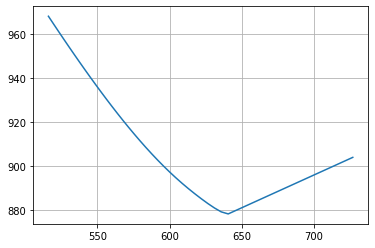

In [18]:
x = []
y = []
for time_step in range(50):
  x.append(train_data[0][time_step][agent][0])
  y.append(train_data[0][time_step][agent][1])

%matplotlib inline
plt.plot(x,y)
plt.grid()
plt.show()

In [19]:
train_data = torch.nn.functional.normalize(train_data)
val_data = torch.nn.functional.normalize(val_data)
test_data = torch.nn.functional.normalize(test_data)

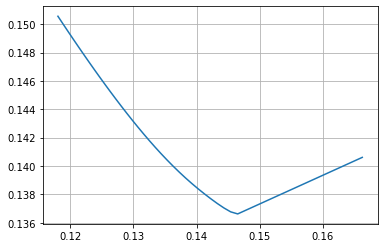

In [20]:
x = []
y = []
for time_step in range(50):
  x.append(train_data[0][time_step][agent][0])
  y.append(train_data[0][time_step][agent][1])
%matplotlib inline
plt.plot(x,y)
plt.grid()
plt.show()

In [21]:
DATA = []

for i in range(train_data.shape[0]):
  DATA.append({'inputs':train_data[i].reshape([1,50,10,4]),'edges':train_edges[i].reshape([1,50,90])})

VAL = []

for i in range(val_data.shape[0]):
  VAL.append({'inputs':val_data[i].reshape([1,50,10,4]),'edges':val_edges[i].reshape([1,50,90])})

TEST = []

for i in range(test_data.shape[0]):
  TEST.append({'inputs':test_data[i].reshape([1,50,10,4]),'edges':test_edges[i].reshape([1,50,90])})

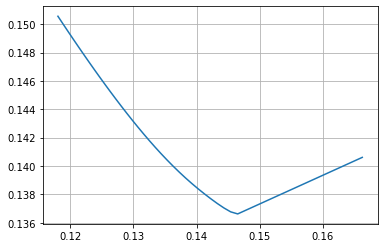

In [22]:
x = []
y = []
for time_step in range(50):
  x.append(DATA[0]['inputs'][0][time_step][a][0])
  y.append(DATA[0]['inputs'][0][time_step][a][1])
%matplotlib inline
plt.plot(x,y)
plt.grid()
plt.show()

In [30]:
model_types = [SingleRNNBaseline,
               JointRNNBaseline,
               FullyConnectedBaseline,
               DNRI,
               BaseNRI 
               ]

Build Model

In [31]:
def build_model(params,model_type):
  model = model_type(params)
  print("################################", type(model).__name__, "################################################")
  #print("################################################################################")
  #print(params['model_type'])
  if params['load_best_model']:
      print("LOADING BEST MODEL")
      path = os.path.join(params['working_dir'], 'best_model')
      model.load(path)
  elif params['load_model']:
      print("LOADING MODEL FROM SPECIFIED PATH")
      model.load(params['load_model'])
  if params['gpu']:
      model.cuda()
  return model

In [32]:
params['mode'] = 'train'
params['num_epochs'] = 50
params['test_burn_in_steps'] =40
params['input_time_steps'] = 50

In [33]:
#params['model_type'] = model_name
metrics = {}
for model_type in model_types:
  model = build_model(params,model_type)
  if params['mode'] == 'train':
      with build_writers(params['working_dir']) as (train_writer, val_writer):
          result = train(model, DATA, VAL, params, train_writer, val_writer)
                                                                   
  metrics[str(type(model).__name__)] = result
  

################################ SingleRNNBaseline ################################################
EPOCH 1 	CURRENT VAL LOSS: 19888480.9375 	BEST VAL EPOCH: -1
EPOCH 2 	CURRENT VAL LOSS: 6067530.1953125 	BEST VAL EPOCH: 2
EPOCH 3 	CURRENT VAL LOSS: 608286.2431640625 	BEST VAL EPOCH: 3
EPOCH 4 	CURRENT VAL LOSS: 1659790.2890625 	BEST VAL EPOCH: 3
EPOCH 5 	CURRENT VAL LOSS: 4389783.3359375 	BEST VAL EPOCH: 3
EPOCH 6 	CURRENT VAL LOSS: 4872676.0859375 	BEST VAL EPOCH: 3
EPOCH 7 	CURRENT VAL LOSS: 3342638.43359375 	BEST VAL EPOCH: 3
EPOCH 8 	CURRENT VAL LOSS: 1445509.013671875 	BEST VAL EPOCH: 3
EPOCH 9 	CURRENT VAL LOSS: 312330.77294921875 	BEST VAL EPOCH: 9
EPOCH 10 	CURRENT VAL LOSS: 131951.42547607422 	BEST VAL EPOCH: 10
EPOCH 11 	CURRENT VAL LOSS: 494505.890625 	BEST VAL EPOCH: 10
EPOCH 12 	CURRENT VAL LOSS: 876623.900390625 	BEST VAL EPOCH: 10
EPOCH 13 	CURRENT VAL LOSS: 987038.4404296875 	BEST VAL EPOCH: 10
EPOCH 14 	CURRENT VAL LOSS: 814548.5380859375 	BEST VAL EPOCH: 10
EPOCH 15 

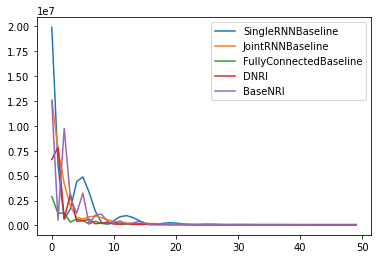

In [34]:
%matplotlib inline
for i in range(len(metrics)):
  plt.plot(list(metrics.values())[i], label = list(metrics.keys())[i])
plt.legend()
plt.show()

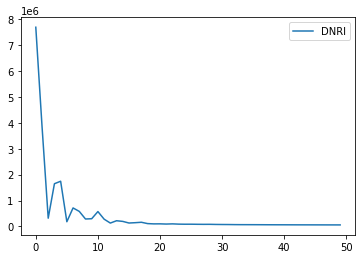

In [28]:
%matplotlib inline
for i in range(len(metrics)):
  plt.plot(list(metrics.values())[i], label = list(metrics.keys())[i])
plt.legend()
plt.show()

In [29]:
dd

NameError: ignored

In [ ]:
model_inputs = TEST[0]['inputs'][:, :40]
model_preds = model.predict_future(model_inputs, 10)
agent = 6
x = []
y = []

for i in range(0,10):
  x.append(float(model_preds[0][i][agent][0]))
  y.append(float(model_preds[0][i][agent][1]))



p = []
q = []

for i in range(0,10):
  p.append(float(TEST[0]['inputs'][:,:-10][0][i][agent][0]))
  q.append(float(TEST[0]['inputs'][:,:-10][0][i][agent][1]))



In [ ]:
plt.scatter(p,q)
plt.grid()

In [ ]:
plt.scatter(x,y)
plt.grid()

In [ ]:
plt.plot(x,y)
plt.plot(p,q)
plt.grid()